# Goal

You need to estimate the total flow of oil, gas, and water through a choke valve. The total flow rate is labeled `QTOT`. You should use all measurements that may explain the total flow. Awesome Corp has already prepared these for you in a dataset (no further preprocessing is required). The measurements (features) are labeled as follows:
- `CHK`: choke opening - a number in [0, 1], 1 meaning fully open and 0 meaning closed
- `PWH`: pressure upstream the choke (scaled)
- `PDC`: pressure downstream the choke (scaled)
- `TWH`: temperature upstream the choke (scaled)
- `FGAS`: fraction of gas to total flow - a number in [0,1]
- `FOIL`: fraction of water to total flow - a number in [0,1]

The location of the sensors are shown in the figure below.

<img src="well_sensors.png">

### Wait! There is one issue. The customer does not have a model for the total flow rate...

A simple choke model for water flow is:
$$QTOT = C_v(CHK) \sqrt{\frac{2(PWH - PDC)}{\rho}}$$
where $C_v(CHK)$ gives the cross-sectional area as a function of choke opening `CHK`.

Unfortunately, there are complications that prevent us from using this model:

1. We do not know what the correct equations are for multi-phase flow. For example, we expect gas expansions to be a factor. This factor is likely dependent on the temperature `TWH` and the amount of gas `FGAS`. Viscosity is probably a factor too, and that would depend on `FOIL`.
2. We do not know the form of the choke $C_v$-curve.

[Head scratch] Perhaps we can use a deep learning algorithm to learn a good representation of the data? Let us try to use all the available measurements to model `QTOT` using a neural network:
$$QTOT = f_{\theta}(CHK, PWH, PDC, TWH, FGAS, FOIL)$$

Let's get to work!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam


# Dataset

In [2]:
df = pd.read_csv('well_data.csv', index_col=0)
df

,CHK,PWH,PDC,TWH,FGAS,FOIL,QTOT
0,0.540,0.542755,0.211586,0.594760,0.138882,0.861118,32.358228
1,0.540,0.542755,0.211586,0.594760,0.142222,0.857774,32.940225
2,0.894,0.458000,0.222654,0.616555,0.144697,0.855303,48.633042
3,0.894,0.452311,0.222556,0.609029,0.144938,0.855056,48.065657
4,0.894,0.443485,0.221839,0.602488,0.144187,0.855807,47.096656
...,...,...,...,...,...,...,...
3094,0.534,0.462606,0.215561,0.592627,0.128039,0.826061,28.108285
3095,0.534,0.462854,0.216331,0.589506,0.127935,0.825378,28.119254
3096,0.534,0.463855,0.239411,0.594895,0.127857,0.824711,27.875849
3097,0.415,0.498174,0.234317,0.581882,0.129256,0.833875,18.412828


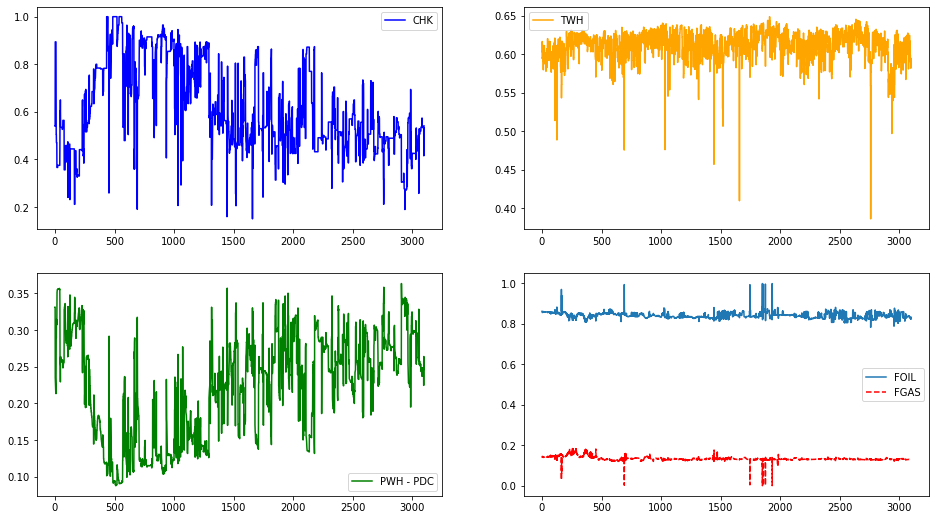

In [3]:
fig, ax = plt.subplots(2, 2, figsize=(16, 9))

# Choke valve opening
ax[0, 0].plot(df['CHK'], label='CHK', color="blue")
ax[0, 0].legend()

# Total floqw through choke valve
ax[0, 1].plot(df['TWH'], label='TWH', color='orange')
ax[0, 1].legend()

# Diff pressure over choke valve
ax[1, 0].plot(df['PWH'] - df['PDC'], label='PWH - PDC', color='green')
ax[1, 0].legend()

# Fractions
ax[1, 1].plot(df['FOIL'], label='FOIL')
ax[1, 1].plot(df['FGAS'], '--r', label='FGAS')
ax[1, 1].legend()

In [4]:
df.corr()

,CHK,PWH,PDC,TWH,FGAS,FOIL,QTOT
CHK,1.000000,-0.963694,0.706279,0.285622,0.091705,-0.087384,0.935945
PWH,-0.963694,1.000000,-0.690669,-0.262040,-0.053365,0.097010,-0.889464
PDC,0.706279,-0.690669,1.000000,0.086445,-0.071751,-0.103538,0.647044
TWH,0.285622,-0.262040,0.086445,1.000000,0.070121,-0.096992,0.372099
FGAS,0.091705,-0.053365,-0.071751,0.070121,1.000000,-0.375864,0.189640
FOIL,-0.087384,0.097010,-0.103538,-0.096992,-0.375864,1.000000,-0.096468
QTOT,0.935945,-0.889464,0.647044,0.372099,0.189640,-0.096468,1.000000


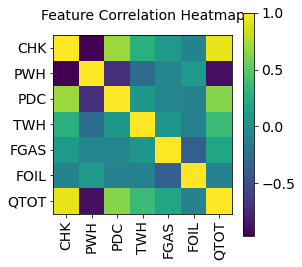

In [5]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

# Split into training and test data



In [6]:
test_set = df.iloc[2000:2500]


x_test = test_set.drop(columns='QTOT')
y_test = test_set[['QTOT']]

#train_val_set = df.copy().drop(test_set.index) 
train_val_set = df.iloc[0:500]

#from sklearn.utils import shuffle
#x_train, y_train = shuffle(x_train, y_train)

df[2000:2500]

,CHK,PWH,PDC,TWH,FGAS,FOIL,QTOT
2000,0.425,0.527707,0.212984,0.612952,0.130376,0.844580,21.673739
2001,0.425,0.528629,0.212680,0.610990,0.130260,0.844662,21.722295
2002,0.432,0.526112,0.213504,0.615925,0.130108,0.844567,22.447193
2003,0.442,0.521003,0.213779,0.617164,0.130366,0.843761,23.563635
2004,0.492,0.501959,0.215607,0.572771,0.130028,0.844019,27.804924
...,...,...,...,...,...,...,...
2495,0.543,0.455476,0.219364,0.610754,0.132488,0.825488,31.328236
2496,0.543,0.456618,0.239781,0.629668,0.130905,0.830545,31.224877
2497,0.543,0.455943,0.221301,0.614983,0.131180,0.828086,31.403480
2498,0.591,0.467060,0.239900,0.616457,0.132519,0.841426,36.492503


In [7]:


val_set = train_val_set.sample(frac=0.1, replace=False)
train_set = train_val_set.copy().drop(val_set.index)


n_points = len(train_set) + len(val_set) + len(test_set)
print(f'{len(df)} = {len(train_set)} + {len(val_set)} + {len(test_set)} = {n_points}')


x_val = val_set.drop(columns='QTOT')
y_val = val_set[['QTOT']]


x_train = train_set.drop(columns='QTOT')
y_train = train_set[['QTOT']]


3099 = 450 + 50 + 500 = 1000


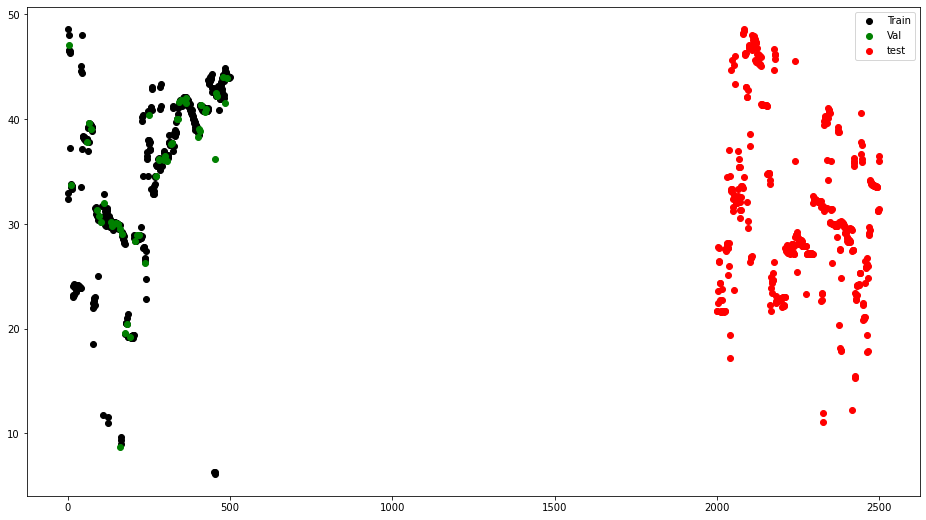

In [8]:
plt.figure(figsize=(16,9))
plt.scatter(y_train.index, y_train.values, color='black', label='Train')
plt.scatter(val_set.index, val_set['QTOT'], color='green', label='Val')
plt.scatter(y_test.index, y_test.values, color='red', label='test')
plt.legend()

# Keras Model

In [9]:
from keras import regularizers
from keras.layers import Dropout

input_layer_size = x_train.columns.size

model = keras.Sequential()

model.add(keras.layers.Dense(input_layer_size, activation='relu', input_shape=(input_layer_size,)))
model.add(keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.Dense(1))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 42        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                224       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,355
Trainable params: 1,355
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [12]:

from keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience=10)


history = model.fit(x_train,y_train,validation_data=(x_val, y_val),epochs=100, batch_size=10, callbacks=[callback],verbose=2)

Epoch 1/100
45/45 - 0s - loss: 1246.4677 - val_loss: 1250.1704
Epoch 2/100
45/45 - 0s - loss: 1181.1322 - val_loss: 1106.9220
Epoch 3/100
45/45 - 0s - loss: 851.7513 - val_loss: 513.2544
Epoch 4/100
45/45 - 0s - loss: 212.4441 - val_loss: 67.0638
Epoch 5/100
45/45 - 0s - loss: 87.2312 - val_loss: 64.0608
Epoch 6/100
45/45 - 0s - loss: 82.9578 - val_loss: 61.9097
Epoch 7/100
45/45 - 0s - loss: 80.9079 - val_loss: 58.2640
Epoch 8/100
45/45 - 0s - loss: 74.8028 - val_loss: 55.5224
Epoch 9/100
45/45 - 0s - loss: 74.0192 - val_loss: 53.1944
Epoch 10/100
45/45 - 0s - loss: 71.0528 - val_loss: 50.5767
Epoch 11/100
45/45 - 0s - loss: 65.7467 - val_loss: 47.9837
Epoch 12/100
45/45 - 0s - loss: 64.7275 - val_loss: 46.0328
Epoch 13/100
45/45 - 0s - loss: 62.4631 - val_loss: 43.1971
Epoch 14/100
45/45 - 0s - loss: 55.0981 - val_loss: 41.7157
Epoch 15/100
45/45 - 0s - loss: 58.7948 - val_loss: 38.2557
Epoch 16/100
45/45 - 0s - loss: 52.3002 - val_loss: 36.0766
Epoch 17/100
45/45 - 0s - loss: 48.187

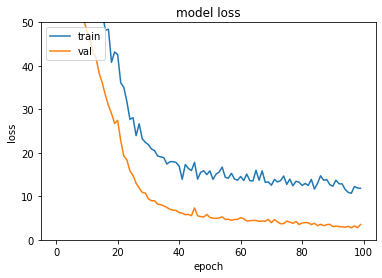

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
axes = plt.gca()
axes.set_ylim([0,50])
plt.show()

In [14]:
keras_predictions = model.predict(x_test, verbose=2)

16/16 - 0s


In [15]:


print("Error on test data")
mse_test = np.mean(np.power(keras_predictions - y_test.values, 2))
print("MSE: ", mse_test) #2.6873526

mae_test = np.mean(np.abs(keras_predictions-y_test.values))
print("MAE: ", mae_test) # 1.12

mape_test = 100*np.mean(np.abs(np.divide(keras_predictions - y_test.values, y_test.values)))
print("MAPE: ", mape_test, "%") # 3.574



Error on test data
MSE:  17.772642494492544
MAE:  3.839999807138368
MAPE:  13.917532938970844 %


# Pytorch model

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader
from math import sqrt

%matplotlib inline

class Net(torch.nn.Module):
    """
    PyTorch offers several ways to construct neural networks.
    Here we choose to implement the network as a Module class.
    This gives us full control over the construction and clarifies our intentions.
    """
    
    def __init__(self, layers):
        """
        Constructor of neural network
        :param layers: list of layer widths. Note that len(layers) = network depth + 1 since we incl. the input layer.
        """
        super().__init__()

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        assert len(layers) >= 2, "At least two layers are required (incl. input and output layer)"
        self.layers = layers

        # Fully connected linear layers
        linear_layers = []

        for i in range(len(self.layers) - 1):
            n_in = self.layers[i]
            n_out = self.layers[i+1]
            layer = torch.nn.Linear(n_in, n_out)

            # Initialize weights and biases
            a = 1 if i == 0 else 2
            layer.weight.data = torch.randn((n_out, n_in)) * sqrt(a / n_in)
            layer.bias.data = torch.zeros(n_out)
            
            # Add to list
            linear_layers.append(layer)
        
        # Modules/layers must be registered to enable saving of model
        self.linear_layers = torch.nn.ModuleList(linear_layers)  

        # Non-linearity (e.g. ReLU, ELU, or SELU)
        self.act = torch.nn.ReLU(inplace=False)

    def forward(self, input):
        """
        Forward pass to evaluate network for input values
        :param input: tensor assumed to be of size (batch_size, n_inputs)
        :return: output tensor
        """
        x = input
        for l in self.linear_layers[:-1]:
            x = l(x)
            x = self.act(x)

        output_layer = self.linear_layers[-1]
        return output_layer(x)

    def get_num_parameters(self):
        return sum(p.numel() for p in self.parameters())

    def save(self, path: str):
        """
        Save model state
        :param path: Path to save model state
        :return: None
        """
        torch.save({
            'model_state_dict': self.state_dict(),
        }, path)

    def load(self, path: str):
        """
        Load model state from file
        :param path: Path to saved model state
        :return: None
        """
        checkpoint = torch.load(path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        self.load_state_dict(checkpoint['model_state_dict'])


In [17]:
def train(
        net: torch.nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        n_epochs: int,
        lr: float,
        l2_reg: float,
) -> torch.nn.Module:
    """
    Train model using mini-batch SGD
    After each epoch, we evaluate the model on validation data

    :param net: initialized neural network
    :param train_loader: DataLoader containing training set
    :param n_epochs: number of epochs to train
    :param lr: learning rate (default: 0.001)
    :param l2_reg: L2 regularization factor (default: 0)
    :return: torch.nn.Module: trained model.
    """

    # Define loss and optimizer
    criterion = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    # Train Network
    for epoch in range(n_epochs):
        for inputs, labels in train_loader:
            # Zero the parameter gradients (from last iteration)
            optimizer.zero_grad()

            # Forward propagation
            outputs = net(inputs)
            
            # Compute cost function
            batch_mse = criterion(outputs, labels)
            
            reg_loss = 0
            for param in net.parameters():
                reg_loss += param.pow(2).sum()

            cost = batch_mse + l2_reg * reg_loss

            # Backward propagation to compute gradient
            cost.backward()
            
            # Update parameters using gradient
            optimizer.step()
        
        # Evaluate model on validation data
        mse_val = 0
        for inputs, labels in val_loader:
            mse_val += torch.sum(torch.pow(labels - net(inputs), 2)).item()
        mse_val /= len(val_loader.dataset)
        print(f'Epoch: {epoch + 1}: Val MSE: {mse_val}')
        
    return net


In [18]:
# Define the target and features
INPUT_COLS = ['CHK', 'PWH', 'PDC', 'TWH', 'FGAS', 'FOIL']
OUTPUT_COLS = ['QTOT']

# Get input and output tensors and convert them to torch tensors
x_train = torch.from_numpy(train_set[INPUT_COLS].values).to(torch.float)
y_train = torch.from_numpy(train_set[OUTPUT_COLS].values).to(torch.float)

x_val = torch.from_numpy(val_set[INPUT_COLS].values).to(torch.float)
y_val = torch.from_numpy(val_set[OUTPUT_COLS].values).to(torch.float)

# Create dataset loaders
# Here we specify the batch size and if the data should be shuffled
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_set), shuffle=False)


In [19]:
layers = [len(INPUT_COLS), 50, 50, len(OUTPUT_COLS)]
net = Net(layers)

print(f'Layers: {layers}')
print(f'Number of model parameters: {net.get_num_parameters()}')
# print(6*50 + 50 + 50*50 + 50 + 50 * 1 + 1)


Layers: [6, 50, 50, 1]
Number of model parameters: 2951


C:\Users\asgeirhu\Anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [20]:
n_epochs = 100
lr = 0.001
l2_reg = 0.001  # 10
net = train(net, train_loader, val_loader, n_epochs, lr, l2_reg)


Epoch: 1: Val MSE: 1002.6909375
Epoch: 2: Val MSE: 472.143046875
Epoch: 3: Val MSE: 65.8768310546875
Epoch: 4: Val MSE: 47.550263671875
Epoch: 5: Val MSE: 44.8427001953125
Epoch: 6: Val MSE: 41.965341796875
Epoch: 7: Val MSE: 37.60037109375
Epoch: 8: Val MSE: 33.2934375
Epoch: 9: Val MSE: 30.1753173828125
Epoch: 10: Val MSE: 24.78550537109375
Epoch: 11: Val MSE: 21.13773193359375
Epoch: 12: Val MSE: 17.482020263671874
Epoch: 13: Val MSE: 14.5402001953125
Epoch: 14: Val MSE: 12.17646728515625
Epoch: 15: Val MSE: 10.6688818359375
Epoch: 16: Val MSE: 10.28537109375
Epoch: 17: Val MSE: 9.369486083984375
Epoch: 18: Val MSE: 8.590114135742187
Epoch: 19: Val MSE: 8.873623046875
Epoch: 20: Val MSE: 7.5964202880859375
Epoch: 21: Val MSE: 7.127429809570312
Epoch: 22: Val MSE: 6.6650018310546875
Epoch: 23: Val MSE: 6.646301879882812
Epoch: 24: Val MSE: 5.891113891601562
Epoch: 25: Val MSE: 5.50443115234375
Epoch: 26: Val MSE: 5.223157348632813
Epoch: 27: Val MSE: 5.074303283691406
Epoch: 28: Val 

In [21]:
# Predict on validation data
pred_val = net(x_val)

# Compute MSE, MAE and MAPE on validation data
print('Error on validation data')

mse_val = torch.mean(torch.pow(pred_val - y_val, 2))
print(f'MSE: {mse_val.item()}')

mae_val = torch.mean(torch.abs(pred_val - y_val))
print(f'MAE: {mae_val.item()}')

mape_val = 100*torch.mean(torch.abs(torch.div(pred_val - y_val, y_val)))
print(f'MAPE: {mape_val.item()} %')


Error on validation data
MSE: 1.4922086000442505
MAE: 0.9347607493400574
MAPE: 2.743947982788086 %


In [22]:
# Get input and output as torch tensors
x_test = torch.from_numpy(test_set[INPUT_COLS].values).to(torch.float)
y_test = torch.from_numpy(test_set[OUTPUT_COLS].values).to(torch.float)

# Make prediction
pred_test = net(x_test)

# Compute MSE, MAE and MAPE on test data
print('Error on test data')

mse_test = torch.mean(torch.pow(pred_test - y_test, 2))
print(f'MSE: {mse_test.item()}')

mae_test = torch.mean(torch.abs(pred_test - y_test))
print(f'MAE: {mae_test.item()}')

mape_test = 100*torch.mean(torch.abs(torch.div(pred_test - y_test, y_test)))
print(f'MAPE: {mape_test.item()} %')


Error on test data
MSE: 26.347396850585938
MAE: 4.811183452606201
MAPE: 17.28168296813965 %


# Compare

In [23]:
print("Error on test data")
mse_test = np.mean(np.power(keras_predictions - y_test.numpy(), 2))
print("MSE: ", mse_test) #2.6873526

mae_test = np.mean(np.abs(keras_predictions-y_test.numpy()))
print("MAE: ", mae_test) # 1.12

mape_test = 100*np.mean(np.abs(np.divide(keras_predictions - y_test.numpy(), y_test.numpy())))
print("MAPE: ", mape_test, "%") # 3.574





Error on test data
MSE:  17.772642
MAE:  3.84
MAPE:  13.917532563209534 %


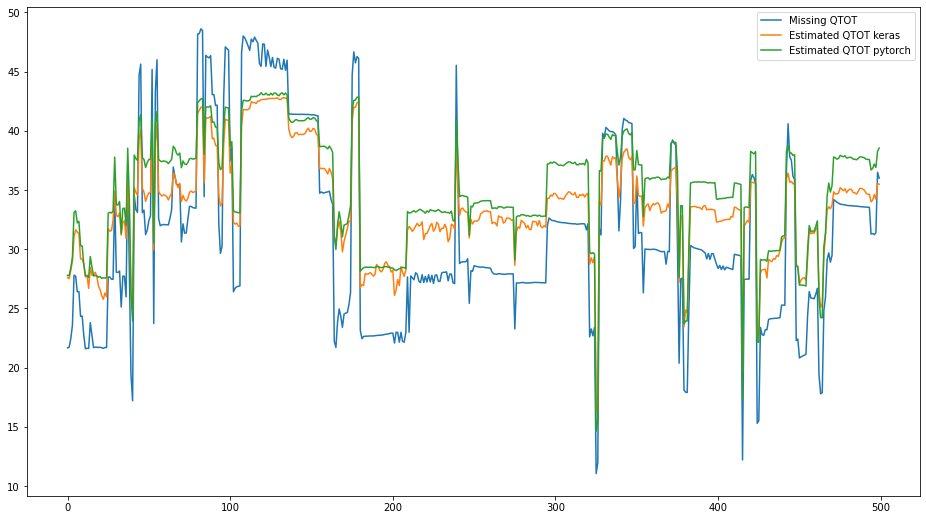

In [24]:
plt.figure(figsize=(16,9))
plt.plot(y_test.numpy(), label='Missing QTOT')
plt.plot(keras_predictions, label='Estimated QTOT keras')
plt.plot(pred_test.detach().numpy(), label='Estimated QTOT pytorch')
plt.legend()